<a href="https://colab.research.google.com/github/mcmejiag/ai-science-training/blob/Homeworks/01_introduction_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 113MB/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 25.5MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 35.2MB/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.11MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

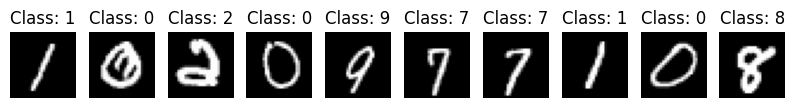

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="images/LinearModel_1.png"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5020800821781158, accuracy: 87.64791666666667
Epoch 0: val. loss: 0.4942354873773899, val. accuracy: 87.75833333333334
Epoch 1: training loss: 0.42174651288986204, accuracy: 89.08125
Epoch 1: val. loss: 0.41209488980313563, val. accuracy: 88.94999999999999
Epoch 2: training loss: 0.38777387952804565, accuracy: 89.71249999999999
Epoch 2: val. loss: 0.3774916962423223, val. accuracy: 89.55
Epoch 3: training loss: 0.36779643336931866, accuracy: 90.14791666666667
Epoch 3: val. loss: 0.357319786352046, val. accuracy: 90.05833333333332
Epoch 4: training loss: 0.35420554625988004, accuracy: 90.42291666666667
Epoch 4: val. loss: 0.34373923232580755, val. accuracy: 90.225
CPU times: user 1min 9s, sys: 134 ms, total: 1min 9s
Wall time: 1min 10s


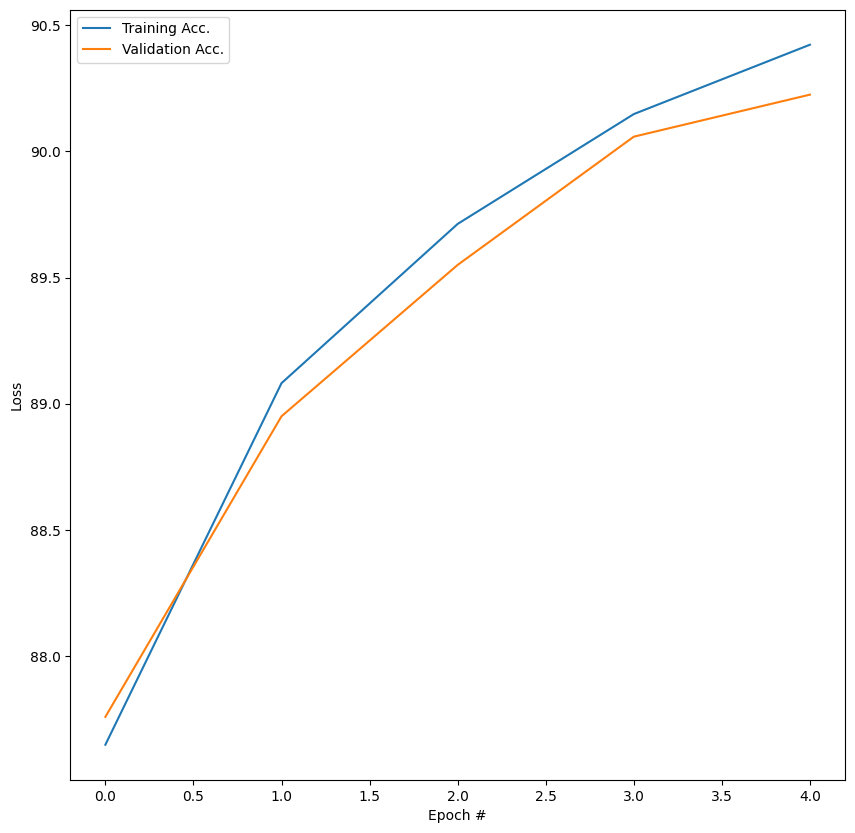

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

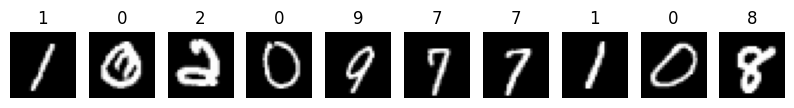

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3327, test accuracy: 90.77%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


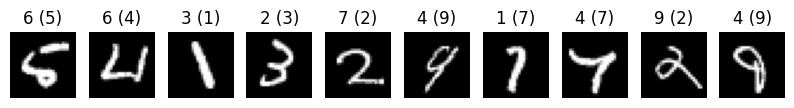

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.8580549766222636, accuracy: 74.87291666666667
Epoch 0: val. loss: 0.846037745475769, val. accuracy: 74.75833333333334
Epoch 1: training loss: 0.4121947084267934, accuracy: 88.46041666666666
Epoch 1: val. loss: 0.40418984820234016, val. accuracy: 88.5
Epoch 2: training loss: 0.31629744402567544, accuracy: 91.00208333333333
Epoch 2: val. loss: 0.3100434880941472, val. accuracy: 91.01666666666667
Epoch 3: training loss: 0.26195180825392406, accuracy: 92.51458333333333
Epoch 3: val. loss: 0.25859609404776956, val. accuracy: 92.28333333333333
Epoch 4: training loss: 0.22941632358233133, accuracy: 93.34791666666666
Epoch 4: val. loss: 0.22881822930054463, val. accuracy: 93.09166666666667
CPU times: user 1min 13s, sys: 184 ms, total: 1min 13s
Wall time: 1min 16s


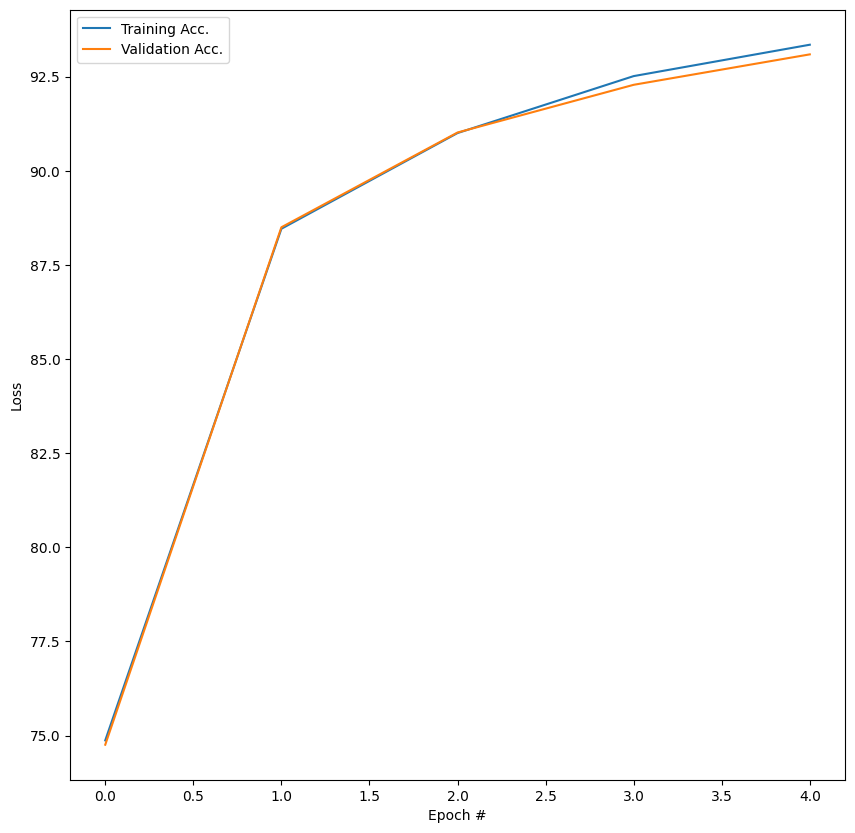

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


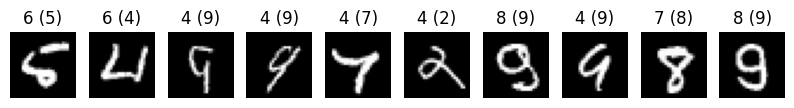

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

# **Homework Solutions**

# 1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

First, let's try changing the values of the batch size, learning rate, and different activation functions. Initially, we tried randomly; we changed the batch size to 32. For the activation functions, we used ReLU, Sigmoid, and Tanh. And for the learning rate, we made it smaller at 0.001. All of these changes make the model take more time to run. In addition,we can observe a significant drop in accuracy.


In [63]:
batch_size = 32

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [64]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x



In [67]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.001)

In [68]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.299825301806132, accuracy: 11.2375
Epoch 0: val. loss: 2.299605670293172, val. accuracy: 11.233333333333333
Epoch 1: training loss: 2.2977874824206035, accuracy: 11.2375
Epoch 1: val. loss: 2.2974727535247803, val. accuracy: 11.233333333333333
Epoch 2: training loss: 2.2958369258244833, accuracy: 11.2375
Epoch 2: val. loss: 2.295496571222941, val. accuracy: 11.233333333333333
Epoch 3: training loss: 2.2935012464523314, accuracy: 11.2375
Epoch 3: val. loss: 2.293147876739502, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.29061326789856, accuracy: 11.2375
Epoch 4: val. loss: 2.2902472286224365, val. accuracy: 11.233333333333333
CPU times: user 1min 28s, sys: 205 ms, total: 1min 28s
Wall time: 1min 30s


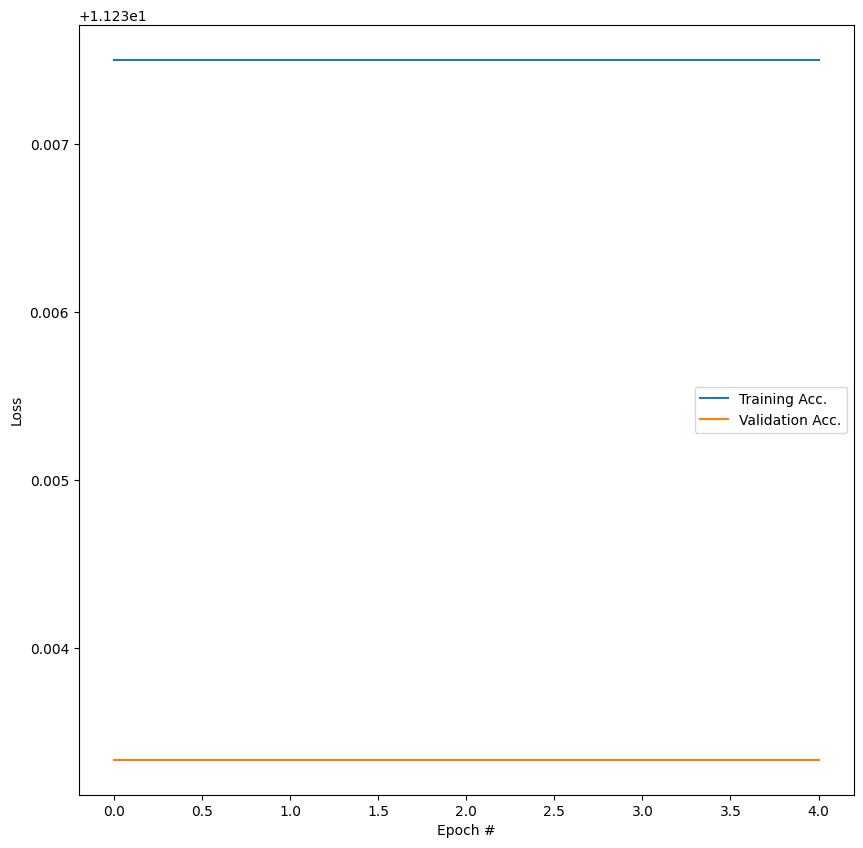

In [69]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

We can see that when we randomly change the learning rate, batch size, and activation functions, our model starts to perform worse than in the previous example. Even then, the validation accuracy and training accuracy are completely different. Therefore, we need to first determine whether the changes in learning rate, batch size, or activation functions are responsible. We need to carefully select the functions, batch size, and learning rate we will use. To do this, we first tried the same code with different learning rates to see which one gives us the best performance.

# Function with different learning rates

In [55]:
def train_and_evaluate_with_lr(learning_rates, epochs, train_dataloader, val_dataloader, model_class, loss_fn_class, batch_size):
    results = {}
    for lr in learning_rates:
        # Initialize the model, loss function, and optimizer for each learning rate
        model = model_class()
        loss_fn = loss_fn_class()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        print(f"\nTraining with learning rate: {lr}")
        train_acc_all = []
        val_acc_all = []

        for j in range(epochs):
            train_one_epoch(train_dataloader, model, loss_fn, optimizer)

            # checking on the training loss and accuracy once per epoch
            train_acc, train_loss = evaluate(train_dataloader, model, loss_fn)
            train_acc_all.append(train_acc)
            print(f"Epoch {j}: training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")

             # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
            val_acc_all.append(val_acc)
            print(f"Epoch {j}: validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

        # Save results for this learning rate
        results[lr] = {
            "train_accuracy": train_acc_all,
            "validation_accuracy": val_acc_all
        }

    return results

In [56]:
# Example usage:
learning_rates = [0.01, 0.03, 0.06, 0.1, 0.05]
epochs = 5

results = train_and_evaluate_with_lr(
    learning_rates=learning_rates,
    epochs=epochs,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_class=NonlinearClassifier,
    loss_fn_class=nn.CrossEntropyLoss,
    batch_size=batch_size
)



Training with learning rate: 0.01
Epoch 0: training loss: 2.2940, accuracy: 9.8667
Epoch 0: validation loss: 2.2945, accuracy: 9.8917
Epoch 1: training loss: 2.2676, accuracy: 19.7979
Epoch 1: validation loss: 2.2680, accuracy: 19.8500
Epoch 2: training loss: 2.2131, accuracy: 22.3375
Epoch 2: validation loss: 2.2132, accuracy: 22.2500
Epoch 3: training loss: 2.0817, accuracy: 38.6437
Epoch 3: validation loss: 2.0816, accuracy: 38.2667
Epoch 4: training loss: 1.8174, accuracy: 44.1833
Epoch 4: validation loss: 1.8169, accuracy: 44.2500

Training with learning rate: 0.03
Epoch 0: training loss: 2.2690, accuracy: 30.3292
Epoch 0: validation loss: 2.2693, accuracy: 30.2667
Epoch 1: training loss: 1.8768, accuracy: 50.6833
Epoch 1: validation loss: 1.8763, accuracy: 50.3917
Epoch 2: training loss: 0.8983, accuracy: 75.5229
Epoch 2: validation loss: 0.8969, accuracy: 74.8417
Epoch 3: training loss: 0.6385, accuracy: 81.9792
Epoch 3: validation loss: 0.6345, accuracy: 81.5667
Epoch 4: train

Here we can observe that the best accuracy and training and validation loss is given when the learning rate is 0.05 and 0.1. We also know that our leanring rate will be better if it is smaller. However, as in the previous example we worked with 0.05. Here we will change also the activation functions and the batch size. Now, we try different batch sized and different learning rates at the same time.

# Function with different learning rates and different batch sizes

In [70]:
import torch
from torch import nn
from torch.utils.data import DataLoader

def train_model_with_params(training_data, validation_data, test_data, batch_sizes, learning_rates, epochs=5):
    results = []

    class NonlinearClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.layers_stack = nn.Sequential(
                nn.Linear(28*28, 50),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, 10)
            )

        def forward(self, x):
            x = self.flatten(x)
            return self.layers_stack(x)

    for batch_size in batch_sizes:
        # Set up the dataloaders for each batch size
        train_dataloader = DataLoader(training_data, batch_size=batch_size)
        val_dataloader = DataLoader(validation_data, batch_size=batch_size)
        test_dataloader = DataLoader(test_data, batch_size=batch_size)

        for lr in learning_rates:
            # Initialize model and optimizer with current learning rate
            model = NonlinearClassifier()
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            train_acc_all = []
            val_acc_all = []

            # Training loop
            for epoch in range(epochs):
                train_one_epoch(train_dataloader, model, loss_fn, optimizer)
                train_acc, train_loss = evaluate(train_dataloader, model, loss_fn)
                train_acc_all.append(train_acc)

                val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
                val_acc_all.append(val_acc)

                print(f"Batch size: {batch_size}, Learning Rate: {lr}, Epoch {epoch}: Training loss: {train_loss}, Training accuracy: {train_acc}, Val loss: {val_loss}, Val accuracy: {val_acc}")

            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'train_accuracy': train_acc_all,
                'val_accuracy': val_acc_all
            })

    return results


In [71]:
batch_sizes = [64, 128, 256]
learning_rates = [0.01, 0.05, 0.1]
results = train_model_with_params(training_data, validation_data, test_data, batch_sizes, learning_rates)


Batch size: 64, LR: 0.01, Epoch 0: Train loss: 2.1680240955352783, Train accuracy: 30.243750000000002, Val loss: 2.1674500361401985, Val accuracy: 30.4
Batch size: 64, LR: 0.01, Epoch 1: Train loss: 1.1219391399224599, Train accuracy: 63.62916666666667, Val loss: 1.114418589688362, Val accuracy: 63.758333333333326
Batch size: 64, LR: 0.01, Epoch 2: Train loss: 0.6911279387076695, Train accuracy: 79.7625, Val loss: 0.6858442409875545, Val accuracy: 79.66666666666666
Batch size: 64, LR: 0.01, Epoch 3: Train loss: 0.4958199275334676, Train accuracy: 86.05208333333333, Val loss: 0.4921013575760608, Val accuracy: 85.90833333333333
Batch size: 64, LR: 0.01, Epoch 4: Train loss: 0.4033857908844948, Train accuracy: 88.76458333333333, Val loss: 0.39959914736608243, Val accuracy: 88.36666666666667
Batch size: 64, LR: 0.05, Epoch 0: Train loss: 0.40012630144755046, Train accuracy: 88.67708333333333, Val loss: 0.3921977480516789, Val accuracy: 88.425
Batch size: 64, LR: 0.05, Epoch 1: Train loss: 

We can observe that the best Validation Accuracy is reach at the batch size 128 and the learning rate 0.1. Now, we will just work with the batch size 128 and the leanring rate 0.1 and we will explore the model performance changing just the activation functions. We tried three different models, one with ReLU, Sigmoid, Tanh. And other model using just Sigmoid and ReLU.

# 1. Model with Sigmoid, ReLU, and Tanh Activations functions. 128 batch size and 0.1 learning rate.

Epoch 0: training loss: 1.0472858088811239, accuracy: 70.51041666666666
Epoch 0: val. loss: 1.040288618270387, val. accuracy: 70.675
Epoch 1: training loss: 0.4822748742898305, accuracy: 87.13541666666667
Epoch 1: val. loss: 0.47311588963295553, val. accuracy: 87.0
Epoch 2: training loss: 0.3505383370320002, accuracy: 90.36666666666666
Epoch 2: val. loss: 0.34238847297556857, val. accuracy: 90.14999999999999
Epoch 3: training loss: 0.27587436827023826, accuracy: 92.48541666666667
Epoch 3: val. loss: 0.26876845163233737, val. accuracy: 92.21666666666667
Epoch 4: training loss: 0.23389166762431463, accuracy: 93.61041666666667
Epoch 4: val. loss: 0.2316172925081659, val. accuracy: 93.39166666666667


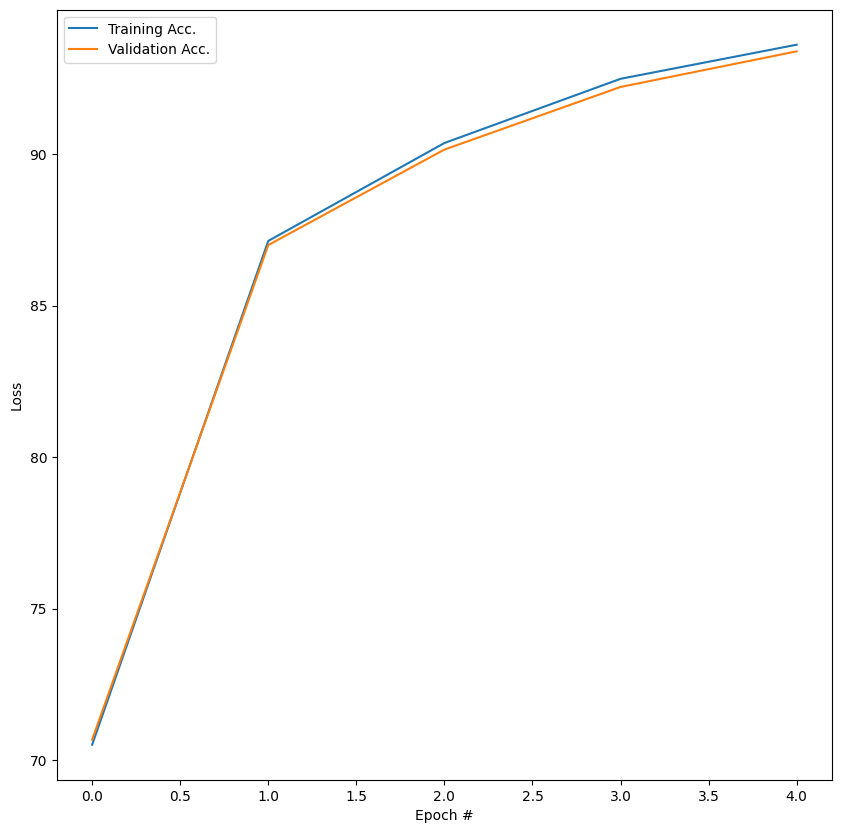

In [73]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)


epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

We can observe that the model performance is good. It is a little bit better that the one performed in class.

# 2. Model with to layers with activation function Sigmoid, one layer with ReLU, Activations function. 128 batch size and 0.1 learning rate.

Epoch 0: training loss: 2.297294724782308, accuracy: 11.504166666666666
Epoch 0: val. loss: 2.2974786682331816, val. accuracy: 11.625
Epoch 1: training loss: 2.2184449348449706, accuracy: 34.766666666666666
Epoch 1: val. loss: 2.217526575352283, val. accuracy: 35.266666666666666
Epoch 2: training loss: 1.5978234539031981, accuracy: 45.00833333333333
Epoch 2: val. loss: 1.591382327231955, val. accuracy: 45.13333333333333
Epoch 3: training loss: 1.0221995080312094, accuracy: 68.5875
Epoch 3: val. loss: 1.0192289631417457, val. accuracy: 68.66666666666667
Epoch 4: training loss: 0.7396484950383504, accuracy: 78.44375
Epoch 4: val. loss: 0.7374491469657167, val. accuracy: 78.475


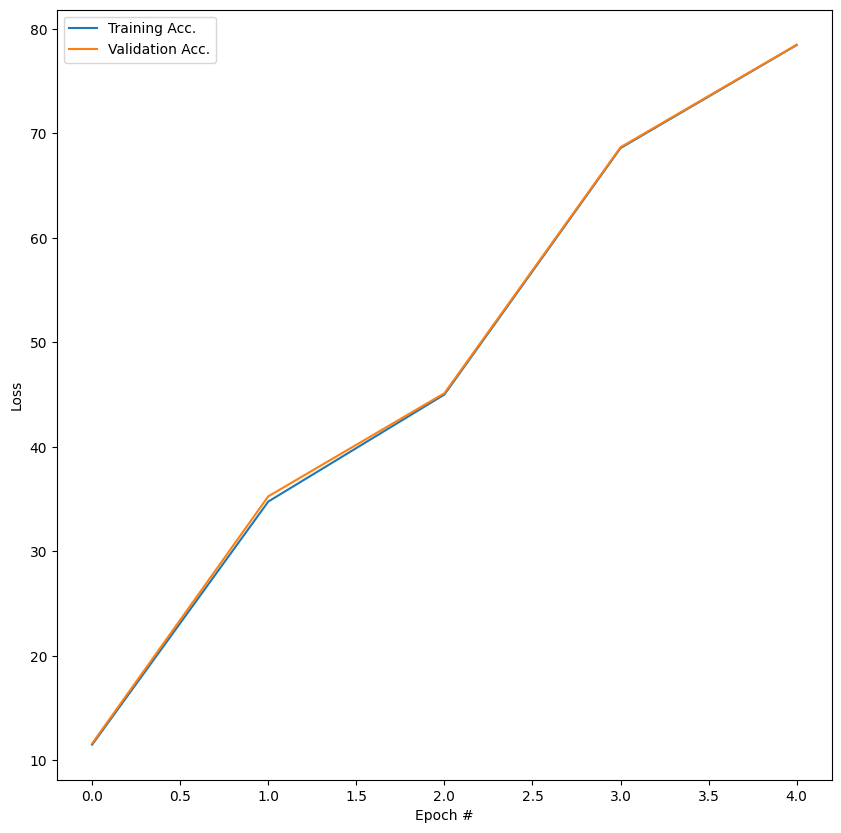

In [74]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)


epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

We can observe that when we exclude the layer with the activiation function Tanh, the model tends to decrease the validation accuracy.

# 3. Model with to layers with activation function Tanh, one layer with ReLU, Activations function. 128 batch size and 0.1 learning rate.

Epoch 0: training loss: 0.38762586609522504, accuracy: 89.53750000000001
Epoch 0: val. loss: 0.3799293304377414, val. accuracy: 89.50833333333334
Epoch 1: training loss: 0.2442096478541692, accuracy: 92.99374999999999
Epoch 1: val. loss: 0.23902246760244064, val. accuracy: 92.77499999999999
Epoch 2: training loss: 0.18805983857313793, accuracy: 94.54791666666667
Epoch 2: val. loss: 0.18795907838230438, val. accuracy: 94.39999999999999
Epoch 3: training loss: 0.15506881763537725, accuracy: 95.39999999999999
Epoch 3: val. loss: 0.16216625063184728, val. accuracy: 95.23333333333333
Epoch 4: training loss: 0.1341753140091896, accuracy: 96.16041666666668
Epoch 4: val. loss: 0.1447978353008945, val. accuracy: 95.65833333333333


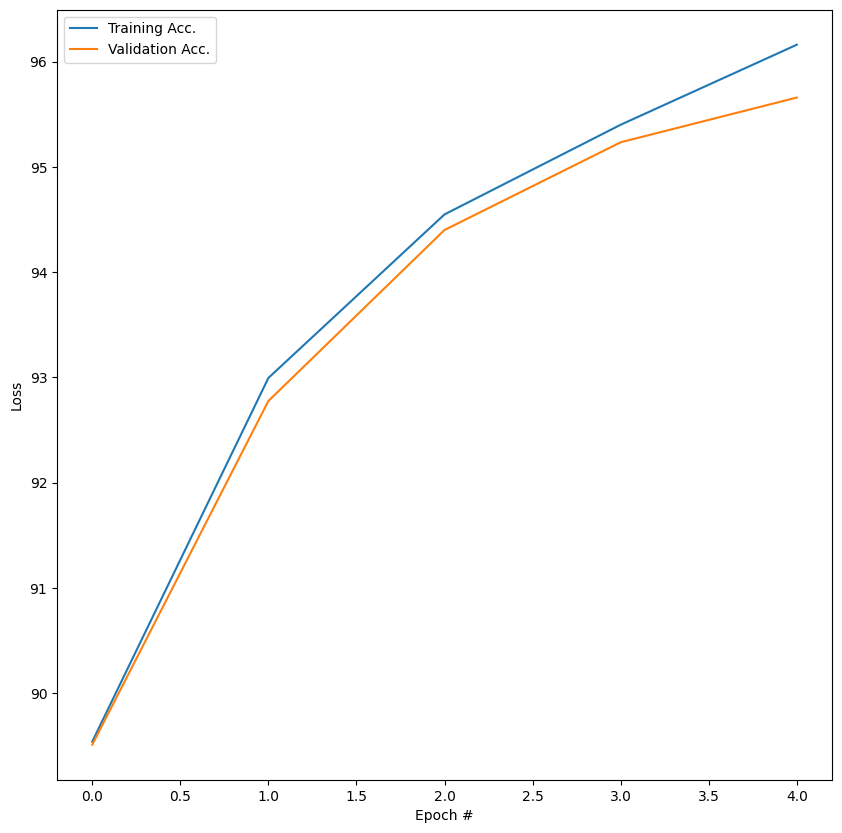

In [75]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)


epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

 We have observed that the model tends to achieve higher validation accuracy when using the Tanh activation function. However, there is a noticeable gap between the training and validation accuracies.

# Bonus: What is a learning rate scheduler?


The learning rate scheduler is an algorithm in which we can adjust the learning rate during the training process between each epoch or iteration. We can use different types of learning rate schedulers: a constant learning rate, that basically initializes the learning rate and does not change it during training, learning rate decay where we select an initial learning rate and reduce it according to the scheduler, and exponential learning rate decay where the learning rate decreases over time. This technique is important for the improvement of model performance. As we can see, changing the learning rate significantly affects the model's performance. Therefore, being able to experiment with different values that are adjusted to the model in order to improve it is really helpful.